# Rupaul's Drag Race Machine

In [112]:
#%matplotlib inline

import pandas as pd
import numpy as np
import math, random
from scipy.stats import rankdata, kendalltau
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

theData = pd.read_csv("dragrace9.csv")
theData= theData.fillna(0)
#theData.iloc[1:10,:]

In [113]:
queens = theData
queens.shape

(114, 18)

In [114]:
# create a function to scale the data for us
def scaleQueens(df):
    """Scale Age, Wins, Highs, Lows, and Lipsyncs in feature data frames"""
    df = df.copy(deep=True)
    df['Age'] = scale(df['Age'])
    df['Wins'] = scale(df['Wins'])
    df['Highs'] = scale(df['Highs'])
    df['Lows'] = scale(df['Lows'])
    df['Lipsyncs'] = scale(df['Lipsyncs'])
    df['Season'] = df['Season']/9
    return df

In [115]:
def compareRanks(x,y):
    """x = actual, y = predicted place"""
    x=np.asarray(x)
    y=np.asarray(y)
    numRanks = np.append(x,y).max()
    actual=np.sum(np.square(x-y))
    worst=np.sum(np.square(np.sort(x)-np.sort(x)[::-1]))
    return 1-2*(actual/worst)

In [116]:
def rankScore(model,x,y):
    ypred = model.predict(x)
    score = compareRanks(y,ypred)
    return score

In [117]:
def createPD(s,queens,yfitpd):
    season = queens.loc[queens.Season==s,['Name','Place']]
    seasonpred = yfitpd.loc[queens.Season==s]
    season['Predicted'] = seasonpred
    season['Predicted'] = rankdata(season.Predicted,method='min')
    season = season.sort_values('Place')
    return season

In [118]:
def predictSeason(season,model,queens,scaled=False):
    Xtrain = queens.loc[queens.Season!=season,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
    Xtest = queens.loc[queens.Season==season,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
    ytrain = queens.loc[queens.Season!=season,'Place']
    if scaled:
        Xtrain = scaleQueens(Xtrain)
        Xtest = scaleQueens(Xtest)
    model.fit(Xtrain,ytrain)
    yfit = model.predict(Xtest)
    pddf = queens.loc[queens.Season==season,['Name','Place']]
    pddf['Predicted'] = rankdata(yfit,method='min')
    return pddf

In [119]:

class neural_network:
    """Defines a neural network, along with attributes for fitting and predicting the network"""
    def __init__(self,size):
        random.seed(0)
        self.network = []
        for i in range(1,len(size)):
            self.network.append([[random.random() for __ in range(size[i-1] + 1)] for __ in range(size[i])])
    
    def sigmoid(self,t): 
        return 1 / (1 + math.exp(-t))
    
    def neuron_output(self,weights, inputs):   #This is a simpler representation; weights for input plus one extra (bias)
        return self.sigmoid(np.dot(weights, inputs))
    
    def feed_forward(self,input_vector):
        outputs = []

        for layer in self.network: #Remember the neural network is given as a list of "layers" which have neurons in them

            input_with_bias = input_vector + [1]          # add a bias input (this just allos us to use a dot product)
            output = [self.neuron_output(neuron, input_with_bias) # compute the output
                      for neuron in layer]                   # for this layer
            outputs.append(output)                           # and remember it

            # the input to the next layer is the output of this one
            input_vector = output

        return outputs
    
    def predict(self,X):
        X = scaleQueens(X)
        predictedY = []
        X = X.values.tolist()
        for i, input in enumerate(X):
            outputs = self.feed_forward(input)[-1]
            predictedY.append(outputs)
        predictedPlace = [a.index(max(a)) for a in predictedY]
        return predictedPlace
    
    
    def convertY(self,Y):
        yNN = [[1 if i == (j-1) else 0 for i in range(0,len(Y)-1)]
               for j in Y ]
        return(yNN)
    
    # define the back-propagation that allows the network to learn
    def backpropagate(self, input_vector, target):
        hidden_outputs, outputs = self.feed_forward(input_vector)

        # the output * (1 - output) is from the derivative of sigmoid
        output_deltas = [output * (1 - output) * (output - target[i])
                         for i, output in enumerate(outputs)]

        # adjust weights for output layer (network[-1])
        for i, output_neuron in enumerate(self.network[-1]):
            for j, hidden_output in enumerate(hidden_outputs + [1]):
                output_neuron[j] -= output_deltas[i] * hidden_output

        # back-propagate errors to hidden layer
        hidden_deltas = [hidden_output * (1 - hidden_output) * 
                          np.dot(output_deltas, [n[i] for n in self.network[-1]]) 
                         for i, hidden_output in enumerate(hidden_outputs)]

        # adjust weights for hidden layer (network[0])
        for i, hidden_neuron in enumerate(self.network[0]):
            for j, input in enumerate(input_vector + [1]):
                hidden_neuron[j] -= hidden_deltas[i] * input
    
    def fit(self,features,targets,times=10000):
        features = scaleQueens(features)
        targets = self.convertY(targets)
        features = features.values.tolist()
        for i in range(times):
            for X, Y in zip(features, targets):
                self.backpropagate(X,Y)
        
        
        

In [120]:

class neural_network:
    """Defines a neural network, along with attributes for fitting and predicting the network"""
    def __init__(self,model):
        self.network = model
    
    def sigmoid(self,t): 
        return 1 / (1 + math.exp(-t))
    
    def neuron_output(self,weights, inputs):   #This is a simpler representation; weights for input plus one extra (bias)
        return self.sigmoid(np.dot(weights, inputs))
    
    def feed_forward(self,input_vector):
        outputs = []

        for layer in self.network: #Remember the neural network is given as a list of "layers" which have neurons in them

            input_with_bias = input_vector + [1]          # add a bias input (this just allos us to use a dot product)
            output = [self.neuron_output(neuron, input_with_bias) # compute the output
                      for neuron in layer]                   # for this layer
            outputs.append(output)                           # and remember it

            # the input to the next layer is the output of this one
            input_vector = output

        return outputs
    
    def predict(self,X):
        predictedY = self.network.predict(X)
        return predictedY
    
    
    def convertY(self,Y):
        yNN = [[1 if i == (j-1) else 0 for i in range(0,len(Y)-1)]
               for j in Y ]
        return(yNN)
    
    # define the back-propagation that allows the network to learn
    def backpropagate(self, input_vector, target):
        hidden_outputs, outputs = self.feed_forward(input_vector)

        # the output * (1 - output) is from the derivative of sigmoid
        output_deltas = [output * (1 - output) * (output - target[i])
                         for i, output in enumerate(outputs)]

        # adjust weights for output layer (network[-1])
        for i, output_neuron in enumerate(self.network[-1]):
            for j, hidden_output in enumerate(hidden_outputs + [1]):
                output_neuron[j] -= output_deltas[i] * hidden_output

        # back-propagate errors to hidden layer
        hidden_deltas = [hidden_output * (1 - hidden_output) * 
                          np.dot(output_deltas, [n[i] for n in self.network[-1]]) 
                         for i, hidden_output in enumerate(hidden_outputs)]

        # adjust weights for hidden layer (network[0])
        for i, hidden_neuron in enumerate(self.network[0]):
            for j, input in enumerate(input_vector + [1]):
                hidden_neuron[j] -= hidden_deltas[i] * input
    
    def fit(self,features,targets,times=10000):
        targets = self.convertY(targets)
        self.network.fit(features,targets)
        
        
        

Initialize the models

In [121]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier

svc_model = SVC(kernel='rbf',gamma=0.01,C=10)
gnb_model = GaussianNB()
rfc_model = RandomForestClassifier(n_estimators=100, random_state=0)
rfr_model = RandomForestRegressor(200,random_state=24601)
#nn_model = neural_network([8,5,14])
nn2_model=MLPClassifier(hidden_layer_sizes=(5,),
                       activation='logistic',
                       solver='lbfgs',
                       random_state=24601)

Have each model predict the rankings and save to a data frame


In [122]:
predictSeason(9,nn2_model,queens,True)

/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


,Name,Place,Predicted
101,Aja,0.0,1
102,Alexis Michelle,0.0,11
103,Charlie Hides,0.0,9
104,Eureka,0.0,4
105,Farrah Moan,0.0,1
106,Jaymes Mansfield,0.0,4
107,Kimora Blac,0.0,4
108,Nina Bo'Nina Brown,0.0,11
109,Peppermint,0.0,9
110,Sasha Velour,0.0,4


In [123]:
the_models = [gnb_model,rfc_model,rfr_model,nn2_model]
model_names = ["GNB","RFC","RFR","NN"]
season = predictSeason(9,svc_model,queens,True)
season['Season'] = 9
season['Model'] = 'SVC'
rank_score = compareRanks(season.Place,season.Predicted)
rsdf = pd.DataFrame({'Season': [9], 'Value': [rank_score], 'Model': ['SVM']})
pred_df = season
rank_scores = rsdf.copy(deep=True)
n = 0
for model in the_models:
    season = predictSeason(9,model,queens,True)
    season['Season'] = 9
    season['Model'] = model_names[n]
    pred_df = pred_df.append(season)
    rank_score = compareRanks(season.Place,season.Predicted)
    rsdf = pd.DataFrame({'Season': [9], 'Value': [rank_score], 'Model': [model_names[n]]})
    rank_scores = rank_scores.append(rsdf)
    n += 1


/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
/Users/thomas/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars
/Users/thomas/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars
/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
/Users/thomas/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars
/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int6

In [124]:
resultsTable = pred_df.pivot_table(index=('Name','Place','Season'),columns='Model').sortlevel(['Season','Place'])
resultsTable = resultsTable.reset_index()
resultsTable['mean'] = resultsTable.mean(axis=1)
resultsTable['PredPlace'] = rankdata(resultsTable['mean'],method='min')
resultsTable.to_csv('PredictedSeason9.csv')
resultsTable.sort_values(by='mean')

Name Place Season Predicted                      mean  \
Model                                        GNB  NN RFC RFR SVC             
6             Kimora Blac   0.0      9         1   4   1   1   3  2.714286   
12              Valentina   0.0      9         1   1   1   5   3  2.857143   
10            Shea Coulee   0.0      9         1   4   1   3   3  3.000000   
2           Charlie Hides   0.0      9         1   9   1   1   1  3.142857   
4             Farrah Moan   0.0      9         1   1   1   8   3  3.285714   
0                     Aja   0.0      9         1   1   1   9   3  3.428571   
8              Peppermint   0.0      9         1   9   1   4   1  3.571429   
9            Sasha Velour   0.0      9         1   4   1  11   3  4.142857   
1         Alexis Michelle   0.0      9         1  11   1   6   3  4.428571   
11         Trinity Taylor   0.0      9         1  11   1   7   3  4.571429   
7      Nina Bo'Nina Brown   0.0      9         1  11   1   9   3  4.857143   
5        Jaymes Mansfield   0.0      9        12   4   1  12  12  7.142857   
3                  Eureka   0.0      9        12   4   1  13  12  7.285714   

      PredPlace  
Model            
6             1  
12            2  
10            3  
2             4  
4             5  
0             6  
8             7  
9             8  
1             9  
11           10  
7            11  
5            12  
3            13

In [125]:
rank_scores

,Model,Season,Value
0,SVM,9,-inf
0,GNB,9,-inf
0,RFC,9,-inf
0,RFR,9,-inf
0,NN,9,-inf


# Based on Princess Points

A group of drag race super fans scored the meet the queens videos for season 8, and then again for season 9. The results below train on season 8 only and then predict season 9.

In [126]:
def predictSeasonPrincess(season,model,queens,scaled=False):
    Xtrain = queens.loc[queens.Season==8,['Age','PuertoRico','PlusSize','Season','PrincessPoints']]
    Xtest = queens.loc[queens.Season==9,['Age','PuertoRico','PlusSize','Season','PrincessPoints']]
    ytrain = queens.loc[queens.Season==8,'Place']
    if scaled:
        Xtrain = scaleQueensPrincess(Xtrain)
        Xtest = scaleQueensPrincess(Xtest)
    model.fit(Xtrain,ytrain)
    yfit = model.predict(Xtest)
    pddf = queens.loc[queens.Season==9,['Name','Place']]
    pddf['Predicted'] = rankdata(yfit,method='min')
    return pddf

In [127]:
# create a function to scale the data for us
def scaleQueensPrincess(df):
    """Scale Age, Wins, Highs, Lows, and Lipsyncs in feature data frames"""
    df = df.copy(deep=True)
    df['Age'] = scale(df['Age'])
    df['PrincessPoints'] = scale(df['PrincessPoints'])
    df['Season'] = df['Season']/9
    return df

In [128]:
the_models = [gnb_model,rfc_model,rfr_model,nn2_model]
model_names = ["GNB","RFC","RFR","NN"]
season = predictSeasonPrincess(9,svc_model,queens,True)
season['Season'] = 9
season['Model'] = 'SVC'
rank_score = compareRanks(season.Place,season.Predicted)
rsdf = pd.DataFrame({'Season': [9], 'Value': [rank_score], 'Model': ['SVM']})
pred_df = season
rank_scores = rsdf.copy(deep=True)
n = 0
for model in the_models:
    if model_names[n] == "GNB" or model_names[n] == "NN":
        season = predictSeasonPrincess(9,model,queens,True)
    else:
        season = predictSeasonPrincess(9,model,queens,False)
    season['Season'] = 9
    season['Model'] = model_names[n]
    pred_df = pred_df.append(season)
    rank_score = compareRanks(season.Place,season.Predicted)
    rsdf = pd.DataFrame({'Season': [9], 'Value': [rank_score], 'Model': [model_names[n]]})
    rank_scores = rank_scores.append(rsdf)
    n += 1

/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
/Users/thomas/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars
/Users/thomas/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars
/Users/thomas/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars
/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [129]:
resultsTable = pred_df.pivot_table(index=('Name','Place','Season'),columns='Model').sortlevel(['Season','Place'])
resultsTable = resultsTable.reset_index()
resultsTable['Mean'] = resultsTable.mean(axis=1)
resultsTable['PredPlace'] = rankdata(resultsTable['Mean'],method='min')
resultsTable = resultsTable.sort_values(by='PredPlace')
resultsTable.to_csv("princessPredictions9.csv")
resultsTable

Name Place Season Predicted                      Mean  \
Model                                        GNB  NN RFC RFR SVC             
12              Valentina   0.0      9         1   1   1   2   4  2.571429   
5        Jaymes Mansfield   0.0      9         1   1   1   4   4  2.857143   
3                  Eureka   0.0      9         1   6   5   1   1  3.285714   
6             Kimora Blac   0.0      9         1   6   1   6   4  3.857143   
9            Sasha Velour   0.0      9         1   1   9   3   4  3.857143   
10            Shea Coulee   0.0      9         1   6   1   7   4  4.000000   
11         Trinity Taylor   0.0      9         1   5   6   9   1  4.428571   
1         Alexis Michelle   0.0      9         1   6   7   8   4  5.000000   
4             Farrah Moan   0.0      9         1   4   9  10   4  5.285714   
0                     Aja   0.0      9         1  12   9   5   4  5.714286   
8              Peppermint   0.0      9         1  10   7  13   3  6.142857   
2           Charlie Hides   0.0      9         1  10   9  12   4  6.428571   
7      Nina Bo'Nina Brown   0.0      9         1  12   9  11   4  6.571429   

      PredPlace  
Model            
12            1  
5             2  
3             3  
6             4  
9             4  
10            6  
11            7  
1             8  
4             9  
0            10  
8            11  
2            12  
7            13

# Just for Fun: Visualizing

In [130]:
from sklearn.decomposition import PCA
import seaborn as sb
sb.set_style("dark")
import matplotlib.pyplot as plt
%pylab inline

pca = PCA(n_components=2)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [131]:
Xtrain = queens.loc[queens.Season!=9,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
ytrain = queens.loc[queens.Season!=9,'Place']

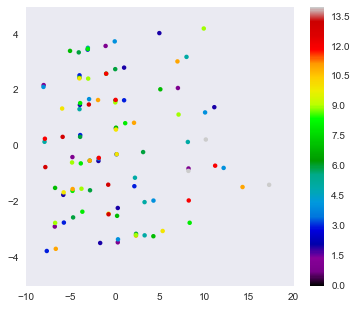

In [132]:
pca.fit(Xtrain)
transform = pca.transform(Xtrain)

figure(figsize(6,5))
plt.scatter(transform[:,0],transform[:,1], s=20, c = ytrain, cmap = "nipy_spectral", edgecolor = "None")
plt.colorbar()
clim(0,14)

# Comparing Neural Networks

In [133]:
nn_sigmoid = MLPClassifier(hidden_layer_sizes=(5,),
                       activation='logistic',
                       solver='lbfgs',
                       random_state=24601)
nn_relu = MLPClassifier(hidden_layer_sizes=(5,),
                       activation='relu',
                       solver='lbfgs',
                       random_state=24601)
nn_tanh = MLPClassifier(hidden_layer_sizes=(5,),
                       activation='tanh',
                       solver='lbfgs',
                       random_state=24601)

In [134]:
from sklearn.model_selection import train_test_split

X = queens.loc[queens.Season!=9,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
Y = queens.loc[queens.Season!=9,'Place']

train = queens.loc[queens.Season<8,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season','Place']]
test = queens.loc[queens.Season==8,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season','Place']]

Xtrain = train.loc[train.Season<8,:]
Xtrain.drop('Place',axis=1,inplace=True)
Xtest = test.loc[test.Season==8,:]
Xtest.drop('Place',axis=1,inplace=True)
ytrain = train.loc[train.Season<8,'Place']
ytest = test.loc[test.Season==8,'Place']

# Xtrain, Xtest, ytrain, ytest = train_test_split(X,Y,random_state=78)

In [135]:
Xtrain = scaleQueens(Xtrain)
Xtest = scaleQueens(Xtest)

/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [136]:
Xtrain.shape

(89, 8)

In [137]:
Xtest.shape

(12, 8)

In [138]:
ytest.shape

(12,)

In [139]:
ytrain.shape

(89,)

## sigmoid

In [140]:
nn_sigmoid.fit(Xtrain,ytrain)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=24601,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [141]:
rankScore(nn_sigmoid,Xtest,ytest)

0.77735849056603779

## ReLU

In [142]:
nn_relu.fit(Xtrain,ytrain)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=24601,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [143]:
rankScore(nn_relu,Xtest,ytest)

0.76226415094339628

## Tanh

In [144]:
nn_tanh.fit(Xtrain,ytrain)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=24601,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [145]:
rankScore(nn_tanh,Xtest,ytest)

0.72452830188679251